In [66]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sn

In [67]:
MAX_MEMORY = '15G'
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY) \
        .set('spark.jars.packages', "com.datastax.spark:spark-cassandra-connector_2.12:3.3.0") \
        .set('spark.cassandra.connection.host', '127.0.0.1') \
        .set('spark.cassandra.connection.port', '9042') \
        .set('spark.cassandra.output.consistency.level','ONE')

In [68]:
spark = SparkSession \
        .builder \
        .appName("Analysis") \
        .config(conf=conf) \
        .getOrCreate()

In [69]:
df_posts = spark.read. \
        format("org.apache.spark.sql.cassandra"). \
        options(table="posts", keyspace="reddit").load()

In [70]:
df_comments = spark.read. \
        format("org.apache.spark.sql.cassandra"). \
        options(table="comments", keyspace="reddit").load()

In [71]:
df_posts.printSchema()

root
 |-- subreddit: string (nullable = false)
 |-- api_timestamp: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- downvotes: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- selftext: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upvotes: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- uuid: string (nullable = true)



In [72]:
df_comments.printSchema()

root
 |-- subreddit: string (nullable = false)
 |-- api_timestamp: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- downvotes: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- permalink: string (nullable = true)
 |-- submission_id: string (nullable = true)
 |-- upvotes: integer (nullable = true)
 |-- uuid: string (nullable = true)



In [73]:
pd.DataFrame(df_posts.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,subreddit,string
1,api_timestamp,timestamp
2,author,string
3,downvotes,int
4,id,string
5,name,string
6,over_18,boolean
7,selftext,string
8,title,string
9,upvotes,int


In [74]:
pd.DataFrame(df_comments.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,subreddit,string
1,api_timestamp,timestamp
2,author,string
3,body,string
4,downvotes,int
5,id,string
6,name,string
7,over_18,boolean
8,permalink,string
9,submission_id,string


## Get num of posts per subreddit

In [75]:
missing_count = df_posts.filter(F.col('selftext') == '').count()

In [76]:
missing_count

5470

In [77]:
df_num_comments = df_comments.groupBy(
    F.col("submission_id")). \
    count(). \
    sort(F.desc("count")). \
    show()

+-------------+-----+
|submission_id|count|
+-------------+-----+
|      149ea3x|  213|
|      146rj9m|  184|
|      147u53z|  170|
|      145bvsi|  149|
|      1490edf|  118|
|      148dm8i|  106|
|      149b7r1|   91|
|      13akk9t|   80|
|      1476mnv|   70|
|      149xhgv|   66|
|      149bakb|   65|
|      147ucd9|   62|
|      1498nva|   57|
|      1440gcw|   55|
|      141fxd1|   55|
|      14a2u7h|   53|
|      147n9eg|   50|
|      144tcf3|   47|
|      149t3dx|   47|
|      1493oql|   44|
+-------------+-----+
only showing top 20 rows



<Axes: xlabel='count', ylabel='subreddit'>

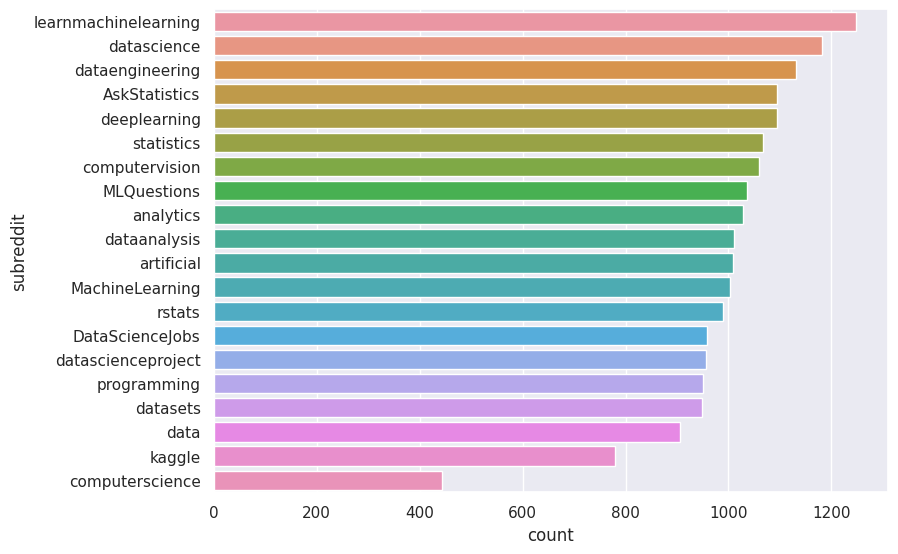

In [85]:
sn.barplot(df_posts.groupBy(col("subreddit")). \
    count(). \
    sort(F.desc("count")). \
    toPandas(),
    y="subreddit", x="count", orient="h"
)


<Axes: xlabel='year', ylabel='count'>

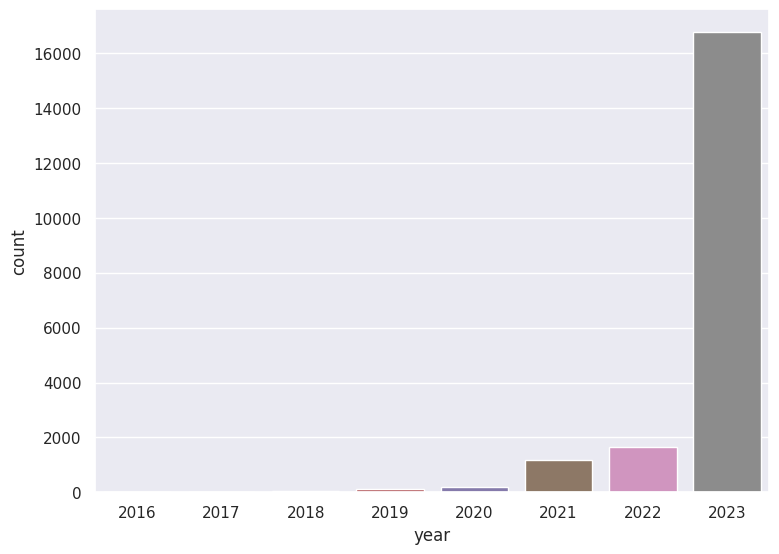

In [86]:
sn.barplot(
    df_posts.groupBy(F.year(F.col("api_timestamp")).alias("year")).count().toPandas(),
    y="count", x="year"
)

<Axes: xlabel='month', ylabel='count'>

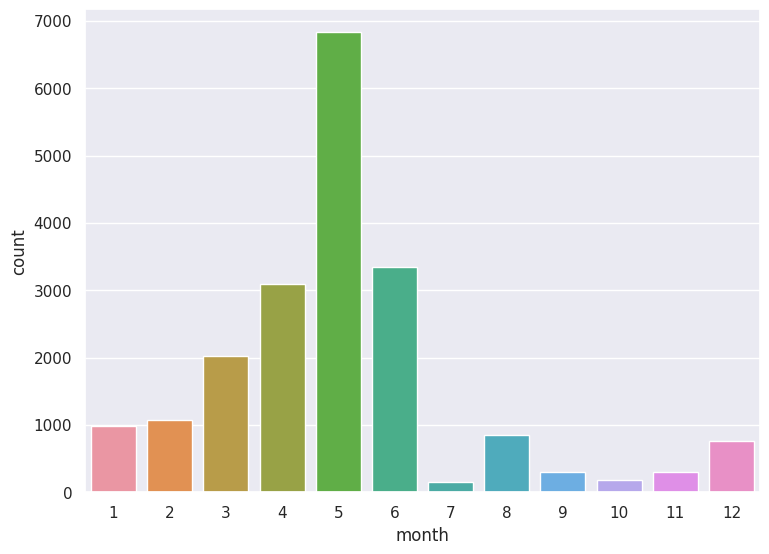

In [89]:
sn.barplot(
    df_posts.groupBy(F.month(F.col("api_timestamp")).alias("month")).count().toPandas(),
    y="count", x="month"
)

<Axes: xlabel='count', ylabel='subreddit'>

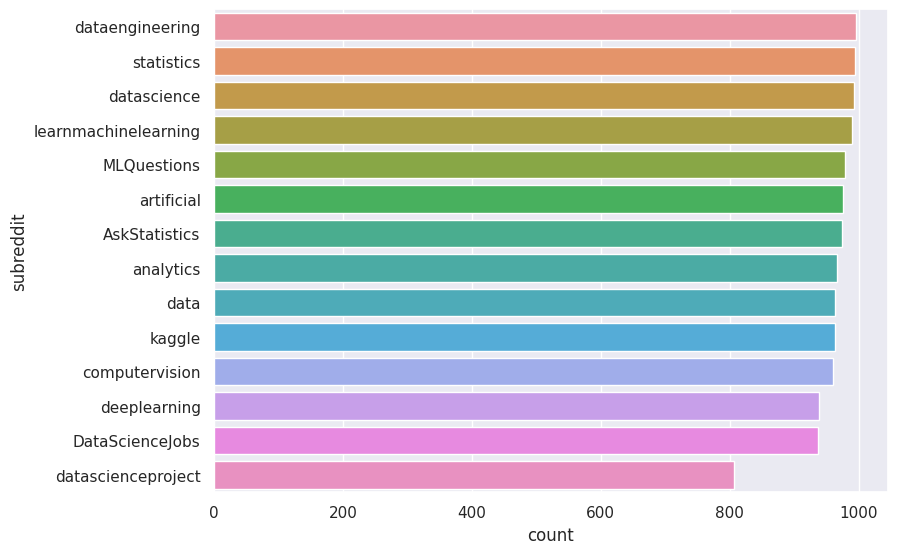

In [87]:
sn.barplot(df_comments.groupBy(F.col("subreddit")). \
    count(). \
    sort(F.desc("count")). \
    toPandas(),
    y="subreddit", x="count", orient="h"
)